Everytime we present results in science, we must also address our uncertainty. This is true any time a measurement is presented, such as in election polling, which why you see polls that report "56% of likely voters prefer candidate A *with a margin of 4 points*." A result without a statement of the uncertainty is basically meaningless.

There are two types of uncertainty we come across in experiments, systematic errors and random errors. A systematic error is uncertainty introduced by the experimental process. For instance, a measurement device could be miscalibrated, or there could be a [loose cable](http://newsfeed.time.com/2012/02/22/einstein-was-right-all-along-faster-than-light-neutrino-was-product-of-error/) that results in faster than light neutrinos. You can also introduce systematic errors through the model you choose. Often, you won't be able to account for every factor affecting your measurements and this will introduce uncertainty in the results.

Random errors are due to fluctuations in the measurement. The uncertainty from random errors can be reduced by repeating the experiment. This type of uncertainty can be quantified by statistical analysis, unlike systematic errors.

Many experiments, especially in life sciences, report uncertainty using hypothesis testing. Hypothesis testing compares experimental results with the *null hypothesis* that the results don't exist. This is done because we know that due to random errors, we might see a large experimental result, even if no true effect exists. 

For instance, if you are testing a pharmaceutical drug, you typically have a control (placebo) group and a treatment group. You find that the drug has some effect - it lowers cholesterol in the treatment group, maybe - and then you ask, "What is the probability I would see this effect due to random fluctuations if there was actually no effect?" Here the null hypothesis is that the two groups have equal means, $\mu_c = \mu_t$. The analysis of this question leads to a *p-value*, the probability you would see an equal or greater effect under the null hypothesis. When the p-value is below some critical value, typically $p < 0.05$, then the result is declared statistically significant and the null hypothesis is rejected. The p-value is at the heart of a massive controversy occuring in science currently, to the point where some journals are [banning hypothesis testing](http://www.tandfonline.com/doi/pdf/10.1080/01973533.2015.1012991) completely.

I will offer my opinions about p-values later, but for now, I want to discuss where the p-value comes from and how it is calculated. Partially I'm doing this because I've seen few places online that explain how it is calculated, mostly because it is somehow [too complicated](https://en.wikipedia.org/wiki/P-value#Calculation), which as you will see, is not true. These days, most statistical testing is done with software packages like R with methods that are basically black boxes. You put your data in, out comes a p-value, then you either get to publish your results or collect more data. Here, I will try to dig into that black box and reveal what is happening.

<!-- fold -->

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb

sb.set_context('notebook', font_scale=1.25)

I'm going to start with the most common hypothesis test, the *t-test*. Here, as with most hypothesis tests, we calculate a test statistic, $t$. Then, we compare $t$ with what we would get from the null hypothesis and calculate a p-value. First, let's see what $t$ statistics we should see under the null hypothesis. To do this, I'm going to simulate drawing samples from normal distributions with the same mean and calculate $t$ for the two samples.

In [2]:
a = np.random.randn(10)+2
b = np.random.randn(10)+2

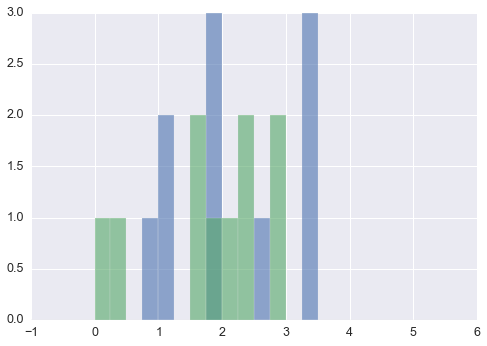

In [3]:
plt.hist(a, range=(-1, 6), bins=28, alpha=0.6)
_ = plt.hist(b, range=(-1, 6), bins=28, alpha=0.6)

The t-test assumes the data is normally distributed. Student's t-test assumes your samples have equal variance and equal sample size. There is a more general test that does not make those assumptions, Welch's t-test. To calculate Welch's t-statistic:

$$
t = \frac{\overline{X}_1 - \overline{X}_2}{\sqrt{\frac{s^2_1}{N_1} + \frac{s^2_2}{N_2}}}
$$

where $\overline{X}_i$, $s^2_i$, and $N_i$ are the sample mean, sample variance, and sample size, respectively, for sample $i$. We also need to calculate the effective degrees of freedom:

$$
\nu = \frac{\left(\frac{s^2_1}{N_1} + \frac{s^2_2}{N_2}\right)^2}{\frac{s^4_1}{N^2_1 \nu_1} + \frac{s^4_2}{N^2_2 \nu_2}}
$$

where $\nu_i = N_i - 1$ is the degrees of freedom of sample $i$.

In [4]:
def welch_t(a, b):
    """ Calculate the t statistic for two samples. """
    diff = a.mean() - b.mean()
    var = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    return diff/var

In [5]:
def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    s_a, s_b = a.var(ddof=1), b.var(ddof=1)
    n_a, n_b = a.size, b.size
    numer = (s_a/n_a + s_b/n_b)**2
    denom = (s_a/ n_a)**2/(n_a - 1) + (s_b/ n_b)**2/(n_b - 1)
    return numer/denom

Now, for the data I generated above:

In [6]:
print("t-statistic: {:.3f}, with degrees of freedom: {:.3f}".\
      format(welch_t(a, b), welch_df(a, b)))

t-statistic: 0.936, with degrees of freedom: 17.999


This result is for two samples drawn from the same distribution. I'm interested in the distribution of $t$ if I calculate $t$ for many samples from this distribution. This will give us a distribution for comparison with $t$ calculated from real data. I'm going to plot the distribution of $t$ for increasing number of simulations to give us a sense of what would happen if we could do this infinite times.

In [7]:
def format_axes(axes):
    for ax in axes:
        ax.set_ylim(0, 0.75)
        ax.set_xlabel("t-statistic")
        _ = ax.legend()
    axes[0].set_ylabel("p(t)")

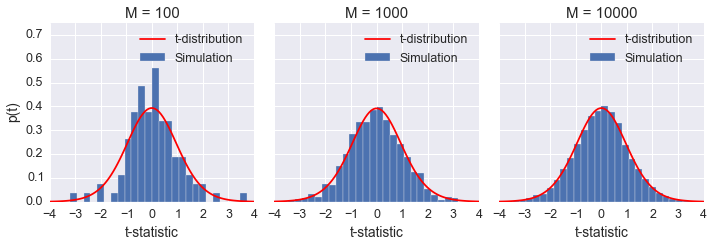

In [8]:
N = 10 # Sample size
mu, sig = 2, 1.5
fig, axes = plt.subplots(figsize=(10,3.5), ncols=3, sharey=True)
for ax, M in zip(axes, [100, 1000, 10000]):
    a = np.random.randn(M, N)*sig + mu
    b = np.random.randn(M, N)*sig + mu
    
    ts = np.array([welch_t(a_i, b_i) for a_i, b_i in zip(a, b)])
    ax.hist(ts, range=(-4,4), bins=30, normed=True, label='Simulation')
    
    df = welch_df(a[0,:], b[0,:])
    x = np.linspace(-4, 4, 100)
    ax.plot(x, stats.t.pdf(x, df), color='r', label='t-distribution')
    
    ax.set_title("M = {}".format(M))
format_axes(axes)
fig.tight_layout()

As the number of simulations gets larger, the distribution of t-statistics becomes closer and closer to the [t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with degrees of freedom calculated from the data. We can use the t-distribution as an approximation of this process, as if we had actually performed the simulation infinite times. Now lets look what happens if we increase the sample size.

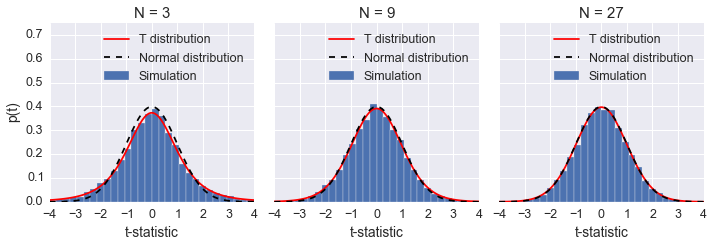

In [9]:
M = 10000 # Simulations
mu, sig = 2, 1.5
fig, axes = plt.subplots(figsize=(10,3.5), ncols=3, sharey=True)
for ax, N in zip(axes, [3, 9, 27]):
    a = np.random.randn(M, N)*sig + mu
    b = np.random.randn(M, N)*sig + mu
    
    ts = np.array([welch_t(a_i, b_i) for a_i, b_i in zip(a, b)])
    ax.hist(ts, range=(-4,4), bins=30, normed=True, label='Simulation')
    
    df = welch_df(a[0,:], b[0,:])
    x = np.linspace(-4, 4, 100)
    ax.plot(x, stats.t.pdf(x, df), 'r', label='T distribution')
    ax.plot(x, stats.norm.pdf(x), '--k', label='Normal distribution')
    ax.set_title("N = {}".format(N))
format_axes(axes)
fig.tight_layout()

As the sample size increases, the t-distribution can be approximated by a normal distribution with zero mean and a variance of one. Now that we see where the t-distribution comes from and that for a large enough sample, it approaches the normal distribution, how is this used to calculate a p-value? Remember that this is the distribution of $t$ for two samples drawn from the same distribution, that is, for the null hypothesis that $\mu_1 = \mu_2$. In a typical experiment, you will have samples from what you believe is two groups, the control group and the treatment group. I'll simulate some data and calculate $t$, then go through how to calculate a p-value.

In [10]:
control = np.random.randn(8)*1.5 + 2
treatment = np.random.randn(12) + 3

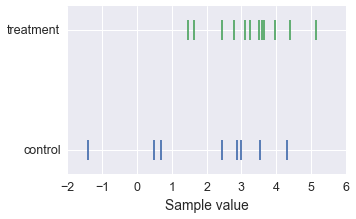

In [11]:
fig, ax = plt.subplots(figsize=(5,3))
colors = sb.color_palette()
ax.scatter(control, np.zeros(len(control)), c=colors[0], 
            marker='|', s=400, linewidths=2, alpha=0.9)
ax.scatter(treatment, np.ones(len(treatment)), color=colors[1],
            marker='|', s=400, linewidths=2, alpha=0.9)
ax.set_yticks([0, 1])
ax.set_yticklabels(['control', 'treatment'])
ax.set_xlabel('Sample value')

In [12]:
t = welch_t(treatment, control)
df = welch_df(treatment, control)

In [13]:
print("t-statistic: {:.3f},"
      " with degrees of freedom: {:.3f}".\
      format(t, df))

t-statistic: 1.702, with degrees of freedom: 9.953


The p-value is the probability we would see a value equal to or more extreme than $t$, under the null hypothesis. This is equivalient to asking, "How likely are we to see our result, or a more extreme result, if there was no true effect?"

We can find this probability using the t-distribution with degrees of freedom as calculated above. There are two different kinds of tests we do, two-tailed and one-tailed tests. Two-tailed tests are used when you want to know if the two samples are different, that is, if $\mu_1 \neq \mu_2$, but you aren't concerned about the direction of the difference. One-tailed tests are used if you want to know if $\mu_1 > \mu_2$ or $\mu_1 < \mu_2$. If we are doing a one-tailed test, then the p-value is simply equal to the area under the t-distribution less than $t$, the shaded area in the figure below.

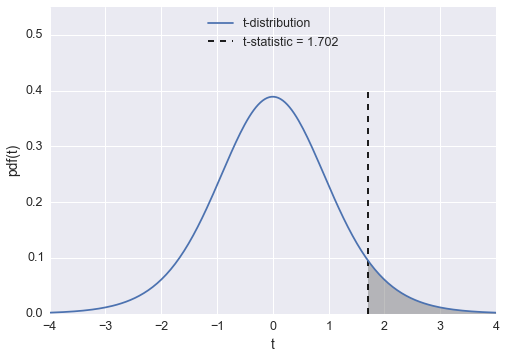

In [14]:
fig, ax = plt.subplots()
x = np.linspace(-4, 4, 200)
t_dist = stats.t.pdf(x, df)
ax.plot(x, t_dist, label='t-distribution')
ax.vlines(t, 0, 0.4, linestyles='--', color='k', 
          label='t-statistic = {:.3f}'.format(t))
ax.set_ylabel('pdf(t)')
ax.set_xlabel('t')
ax.set_ylim(0, 0.55)
ax.legend(loc=9)
ax.fill_between(x, 0, t_dist, where=(x >= t), color='grey', alpha=0.5)

The easiest way to calculate the shaded area is with the cumulative density function (cdf). The cdf at $t$ is equal to the area under the curve for all values less than $t$.

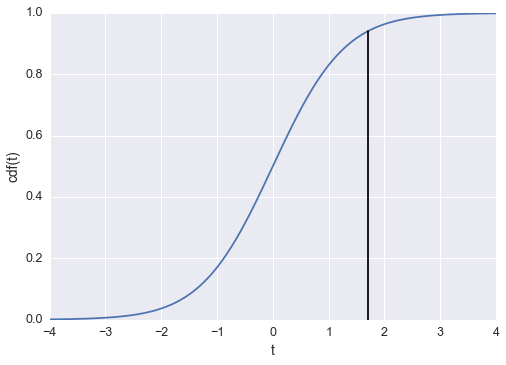

In [15]:
p = stats.t.cdf(t, df)
plt.plot(x, stats.t.cdf(x, df))
plt.plot([t, t], [0, p], color='k')
plt.ylabel('cdf(t)')
plt.xlabel('t')

In [16]:
p = 1 - stats.t.cdf(t, df)
print("One tailed p: {:.4f}".format(p))

One tailed p: 0.0598


In this case, there is a 5.98% probability we would see $t$ equal to or greater than what we saw from our data. We would not be able to reject the null hypothesis since $p$ is not less than 0.05. Basically, the probability that our result isn't due to a statistical fluctiation is not small enough that we can reject the possibility that the null hypothesis is true. The critical value is typically chosen at $p < 0.05$, I believe because this is roughly two standard deviations from zero.

The two-tailed p-value is simply twice the one-tailed value, because we want the probability where $t < -\lvert\hat{t}\rvert$ and $t > \lvert\hat{t}\rvert$, where $\hat{t}$ is the t-statistic calculated from our data. Also, we can take advantage of the symmetry of the t-distribution to calculate only one side. Now we can write a function that calculates the p-value for two samples.

In [17]:
def p_value(a, b):
    "Calculate two-sided t-test for two samples a and b."
    t = welch_t(b, a)
    df = welch_df(b, a)
    p = stats.t.cdf(-np.abs(t), df)
    return t, 2*p

Now I'm going to explore how the p-value depends on various things like sample size and effect size. Here I will take the effect size as the difference in means between two samples from normal distributions with variances of one. An effect size of 1 is the same size as the noise, while 0.2 is one-fifth the size of the noise.

In [18]:
def simulate_experiment(N, effect=1, delta=False):
    control = np.random.randn(N)
    treatment = np.random.randn(N) + effect
    t, p = p_value(control, treatment)
    if delta:
        return treatment.mean() - control.mean(), p
    else:
        return p

Ns = np.linspace(2,300).astype(int) # Sample sizes
M = 1000 # Simulations
ps1 = np.array([sum(simulate_experiment(N, 0.2) for m in range(M))/M
               for N in Ns])
ps2 = np.array([sum(simulate_experiment(N, 0.5) for m in range(M))/M
               for N in Ns])
ps3 = np.array([sum(simulate_experiment(N, 1) for m in range(M))/M
               for N in Ns])

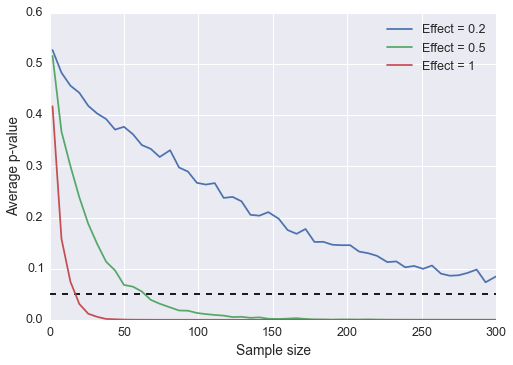

In [19]:
plt.plot(Ns, ps1, label="Effect = 0.2")
plt.plot(Ns, ps2, label="Effect = 0.5")
plt.plot(Ns, ps3, label="Effect = 1")
plt.hlines(0.05, 0, 300, linestyles='--', color='k')
plt.ylabel("Average p-value")
plt.xlabel("Sample size")
plt.legend()

What we see here is that the p-value is a function of the sample size. This means that regardless of effect size, if you have a large amount of data, you will get a significant p-value. It also means that if you don't have a significant p-value, an effect isn't rejected, you just can't see it through the noise.

Now lets look at how the p-values depend on effect size. Here I'll simulate a bunch of experiments so we can see the distribution of p-values we get.

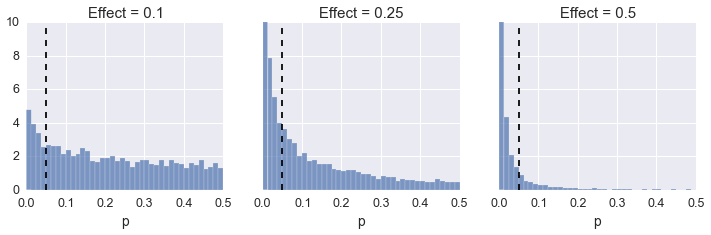

In [387]:
fig, axes = plt.subplots(figsize=(12,3), ncols=3, sharey=True)
effect_sizes = [0.1, 0.25, 0.5]
effects = [[simulate_experiment(100, effect=e) for m in range(10000)]
           for e in effect_sizes]
for i, each in enumerate(effects):
    ax = axes[i]
    ax.hist(each, range=(0, 0.5), bins=40, normed=True, alpha=0.7)
    ax.vlines(0.05, 0, 100, color='k', linestyles='--')
    ax.set_title('Effect = {}'.format(effect_sizes[i]))
    ax.set_xlabel('p')
    ax.set_ylim(0, 10)

Here are the probabilities to get $p < 0.05$ for each effect size.

In [421]:
for i, each in enumerate(effects):
    print('Effect = {}, P(p < 0.05): {}'.\
          format(effect_sizes[i], (np.array(each) < 0.05).mean()))

Effect = 0.1, P(p < 0.05): 0.1087
Effect = 0.25, P(p < 0.05): 0.421
Effect = 0.5, P(p < 0.05): 0.9447


A funny thing can be seen from the second set of simulations with an effect of $0.25$. If this same experiment were replicated in multiple labs in multiple locations, the chance that one particular experiment would find a statistically significant effect is about the same as getting heads from a coin flip.

Next I want to explore what sort of effects sizes we can actually detect when the effect size is small, 0.1 in my example below. I'm also going to use a medium sample size of 100.

In [397]:
N = 100 # Sample size
M = 10000 # Number of simulations
experiments = (simulate_experiment(N, effect=0.1, delta=True) for m in range(M))
results = [each[0] for each in experiments if each[1] < 0.05]

I'm going to plot a histogram of the effects of experiments in which the null hypothesis was rejected. I will also plot a line indicating the true effect, and some more lines indicating multiples of the true effect to aid in interpreting the data.

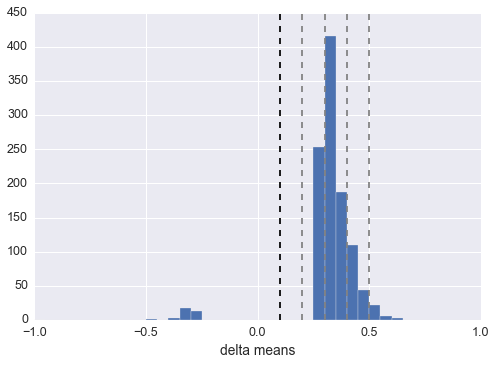

In [398]:
_ = plt.hist(results, range=(-1, 1), bins=40)
plt.xlabel('delta means')
plt.vlines(0.1, 0, 450, color='k', linestyles='--')
plt.vlines([0.2, 0.3, 0.4, 0.5], 0, 450, color='grey', linestyles='--')

We see here that the magnitude of the effect is overestimated by a factor of 3 or 4 when the hypothesis is rejected. In fact, the hypothesis will be rejected only if the effect from our samples is overly large. What's even worse, there are cases where the discovered effect has the opposite sign of the true effect. [Andrew Gelman](http://andrewgelman.com/) calls these errors type M (magnitude) and type S (sign) errors, and discusses them more in [this paper](http://www.stat.columbia.edu/~gelman/research/published/PPS551642_REV2.pdf).

Finally, time to wrap this up and try to summarize the results, with a little editorializing on my part.

For large effects, hypothesis testing is redundant, it is obvious the means are different. For large data, you are almost guaranteed to find some effect. For medium effects with medium data, getting a p-value less than 0.05 is basically a coin toss. For small effects, if you do reject the null hypothesis, you are likely overestimating the effect or have it in the wrong direction. Here, we aren't even getting into the [multiple comparisons problems and how people interpret p-values](https://xkcd.com/882/). I'm also not addressing how scientists abuse the p-value through [p-hacking](http://www.nature.com/news/scientific-method-statistical-errors-1.14700). 

I don't think that p-values should be done away with completely. The first thing that needs to be addressed is the godly number in science, 0.05. It's absurd that a p-value of 0.0500001 will make your research unpublishable, but 0.0499999 could send it to Nature. Too many times I've seen a scientist present an interesting result, then say "But the p-value is only 0.06..." followed by a sigh or groan. Also, when a p-value is reported as $p < 0.05$, is it 0.0499999? Or 0.011? Why not just report the number? Furthermore, negative results are many times just as interesting as positive results. What I'm getting at is that scientific work should be judged on the hypothesis, the methods, and how well the evidence supports the hypothesis, not if p is less than the magical number 0.05. Hypothesis testing can certainly be performed, but the p-value should be presented as part of the evidence, then the reader can decide to believe the result or not. 

I personally find it frustrating when critics don't offer alternatives, so here is my suggestion. My prefered solution is to focus on parameter estimation, particularly with Bayesian inference. Because of problems with p-values and the abuse hypothesis testing has seen, there seems to be a swing back to Bayesian statistics. I personally don't like "classical" frequentist methods, a large part of it is the difference in [philosophy](https://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/): frequentist methods pretend you perform the experiment infinite times, while Bayesian methods use the one dataset you actually collected to calculate likely parameters of the model. To learn more about Bayesian methods, see [this series](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) by Jake VanderPlas, and [this online textbook](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) about probabilistic programming.